# __Import & config__

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('C:\\Users\\Usuario\\TFG\\digipanca\\')

In [2]:
import os
import torch
import numpy as np
import nibabel as nib

from src.utils.config import load_config
from src.utils.evaluation import load_trained_model
from src.inference.predicter import Predicter2D, Predicter3D

# __Functions__

In [ ]:
import numpy as np
import nibabel as nib
from scipy.ndimage import zoom
from nibabel.orientations import apply_orientation, ornt_transform, io_orientation

class ReversePreprocessing:
    def __init__(
        self,
        original_affine,
        original_spacing,
        target_spacing,
        crop_params,
        rotation_axes=(0,1)
    ):
        self.original_affine = original_affine
        self.original_spacing = original_spacing
        self.target_spacing = target_spacing
        self.rotation_axes = rotation_axes
        self.crop_params = crop_params
        self.match_original = match_original

    def __call__(self, prediction, affine=None):
        # Step 1: Undo cropping/padding
        h_min, h_max = self.crop_params["h_min"], self.crop_params["h_max"]
        w_min, w_max = self.crop_params["w_min"], self.crop_params["w_max"]
        restored = np.zeros((512, 512, prediction.shape[2]), dtype=prediction.dtype)
        restored[h_min:h_max, w_min:w_max, :] = prediction

        # Step 2: Undo rotation
        restored = np.rot90(restored, k=1, axes=self.rotation_axes)

        # Step 3: Resample to original spacing if match_original is True
        if self.match_original:
            zoom_factors = np.array(self.target_spacing) / np.array(self.original_spacing)
            restored = zoom(restored, zoom_factors, order=0)  # Nearest-neighbor interpolation

        # Step 4: Update affine matrix
        if self.match_original:
            updated_affine = self.original_affine
        else:
            updated_affine = affine if affine is not None else self.original_affine

        return restored, updated_affine

# __Predict__

In [3]:
config = load_config('configs/experiments/deep_aug_5.yaml')
model_path = 'experiments/deep_aug/deep_aug_20250415_215856/checkpoints/best_model_epoch60.pth'
model = load_trained_model(config, model_path)
config_device = config['training']['device']
device = torch.device(config_device if torch.cuda.is_available() else "cpu")
test_dir = 'data/processed/2d/train/'
patient_ids = ["rtum79", "rtum1", "rtum33", "rtum3", "rtum20", "rtum70", "rtum19", "rtum26", "rtum13", "rtum71", "rtum87", "rtum69", "rtum58", "rtum82", "rtum86", "rtum68", "rtum4", "rtum81"]

In [4]:
predicter = Predicter2D(model, config, device, test_dir)

In [5]:
patient_id = 'rtum79'
predictions, masks = predicter.predict_patient(patient_id)
print(f"predictions: {predictions.shape}")
print(f"masks: {masks.shape}")

  0%|          | 0/26 [00:00<?, ?it/s]

predictions: torch.Size([1, 5, 103, 256, 256])
masks: torch.Size([1, 103, 256, 256])


# __Test__

## 1. Prepare output

In [80]:
from src.utils.tensors import prepare_tensors_for_visualization
pred_np, mask_np, _ = prepare_tensors_for_visualization(predictions, masks, None)
print(f"pred: {pred_np.shape}")
print(f"mask: {mask_np.shape}")

pred: (103, 256, 256)
mask: (103, 256, 256)


In [81]:
# Transpose: (D, H, W) -> (H, W, D)
pred_np = np.transpose(pred_np, (1, 2, 0))
mask_np = np.transpose(mask_np, (1, 2, 0))
print(f"pred: {pred_np.shape}")
print(f"mask: {mask_np.shape}")

pred: (256, 256, 103)
mask: (256, 256, 103)


## 2. ROI focus

In [82]:
# Crop parameters
h_min, h_max = 114, 370
w_min, w_max = 158, 414

In [83]:
D = pred_np.shape[2]
rpred = np.zeros((512, 512, D), dtype=pred_np.dtype)
rpred[h_min:h_max, w_min:w_max, :] = pred_np
rmask = np.zeros((512, 512, D), dtype=mask_np.dtype)
rmask[h_min:h_max, w_min:w_max, :] = mask_np
print(f"rpred: {rpred.shape}")
print(f"rmask: {rmask.shape}")

rpred: (512, 512, 103)
rmask: (512, 512, 103)


## 3. Rotation

In [84]:
rpred = np.rot90(rpred, k=1, axes=(0,1)) # rotate in plane H,W
rmask = np.rot90(rmask, k=1, axes=(0,1))
print(f"rpred: {rpred.shape}")
print(f"rmask: {rmask.shape}")

rpred: (512, 512, 103)
rmask: (512, 512, 103)


## 4. Orientation

In [12]:
from nibabel.orientations import io_orientation, axcodes2ornt, ornt_transform, apply_orientation

In [85]:
# Define orientations
current_orientation = axcodes2ornt(('R', 'P', 'S'))
target_orientation = axcodes2ornt(('L', 'P', 'S'))

# Compute the transformation to the target orientation
transform = ornt_transform(current_orientation, target_orientation)

# Apply the orientation transformation
rpred = apply_orientation(rpred, transform)
rmask = apply_orientation(rmask, transform)

print(f"rpred: {rpred.shape}")
print(f"rmask: {rmask.shape}")

rpred: (512, 512, 103)
rmask: (512, 512, 103)


## 5. Crop/pad to size

## 6. Resampling

In [10]:
from src.data.preprocessing import resample_mask_spacing, update_affine
def get_original_data(data_dir, patient_id):
    vol_dir = os.path.join(data_dir, patient_id, 'SEQ', f'CTport-{patient_id}.nii')
    image_nii = nib.load(vol_dir)

    affine = image_nii.affine.copy()
    spacing = image_nii.header.get_zooms()[:3]

    orientation = nib.aff2axcodes(image_nii.affine)
    print(orientation)

    return affine, spacing

In [90]:
original_affine, original_spacing = get_original_data('data/raw/train/', 'rtum79')
print(original_affine)
print(original_spacing)

('L', 'P', 'S')
[[ -0.87109375   0.           0.         214.        ]
 [  0.          -0.87109375   0.          90.        ]
 [  0.           0.           1.         249.        ]
 [  0.           0.           0.           1.        ]]
(0.87109375, 0.87109375, 1.0)


In [44]:
rpred = resample_mask_spacing(rpred, original_spacing, (0.8,0.8,1.0))
rmask = resample_mask_spacing(rmask, original_spacing, (0.8,0.8,1.0))
print(f"rpred: {rpred.shape}")
print(f"rmask: {rmask.shape}")

rpred: (470, 470, 103)
rmask: (470, 470, 103)


## 7. Saving

In [51]:
def save_pred_mask(pred, mask, path, affine, ext=""):
    # Ensure type
    pred = pred.astype(np.uint8)
    mask = mask.astype(np.uint8)
    
    # Images
    nifti_pred = nib.Nifti1Image(pred, affine=affine)
    nifti_mask = nib.Nifti1Image(mask, affine=affine)
    
    # Save
    nib.save(nifti_pred, os.path.join(save_path, f'pred_{ext}.nii'))
    nib.save(nifti_mask, os.path.join(save_path, f'mask_{ext}.nii'))

In [9]:
def save_mask(mask, path, affine, ext=""):
    # Ensure type
    mask = mask.astype(np.uint8)
    
    # Images
    nifti_mask = nib.Nifti1Image(mask, affine=affine)
    
    # Save
    nib.save(nifti_mask, os.path.join(save_path, f'mask_{ext}.nii'))

In [33]:
save_path = 'test_save/'

# Ensure type
rpred = rpred.astype(np.uint8)
rmask = rmask.astype(np.uint8)

# Images
nifti_pred = nib.Nifti1Image(rpred, affine=original_affine)
nifti_mask = nib.Nifti1Image(rmask, affine=original_affine)

# Save
nib.save(nifti_pred, os.path.join(save_path, 'pred.nii'))
nib.save(nifti_mask, os.path.join(save_path, 'mask.nii'))

## 8. Check padding

In [14]:
from src.data.preprocessing import crop_or_pad_to_size

In [68]:
full_pred = crop_or_pad_to_size(rpred, (512,512))
full_mask = crop_or_pad_to_size(rmask, (512,512))
print(f"full pred: {full_pred.shape}")
print(f"full mask: {full_mask.shape}")

full pred: (512, 512, 103)
full mask: (512, 512, 103)


In [69]:
save_pred_mask(full_pred, full_mask, save_path, original_affine, ext='padded')

In [66]:
zoom_factors = np.array(original_spacing) / np.array((.8, .8, 1.))
print(zoom_factors)
target_size = np.round(512*zoom_factors[0]).astype(np.int64)
print(target_size)
target_size = (target_size, target_size)
print(target_size)

[1.08886719 1.08886719 1.        ]
558
(558, 558)


In [86]:
full_pred = crop_or_pad_to_size(rpred, target_size)
full_mask = crop_or_pad_to_size(rmask, target_size)
print(f"full pred: {full_pred.shape}")
print(f"full mask: {full_mask.shape}")

full pred: (558, 558, 103)
full mask: (558, 558, 103)


In [87]:
rpred = resample_mask_spacing(full_pred, original_spacing, (0.8,0.8,1.0))
rmask = resample_mask_spacing(full_mask, original_spacing, (0.8,0.8,1.0))
print(f"rpred: {rpred.shape}")
print(f"rmask: {rmask.shape}")

rpred: (512, 512, 103)
rmask: (512, 512, 103)


In [88]:
save_pred_mask(full_pred, full_mask, save_path, original_affine, ext='padded')

# __New test__

In [103]:
import matplotlib.pyplot as plt
from src.utils.visualization import CMAP, NORM
def show_mask_slice(mask_slice, title="Mask Slice", figsize=(6, 6)):
    masked = np.ma.masked_where(mask_slice == 0, mask_slice)

    plt.figure(figsize=figsize)
    plt.imshow(masked, cmap=CMAP, norm=NORM)
    plt.title(f"{title} - {mask_slice.shape}")
    plt.axis('off')

    cbar = plt.colorbar(ticks=[1, 2, 3, 4])
    cbar.ax.set_yticklabels(['Pancreas', 'Tumor', 'Arteries', 'Veins'])

    plt.show()

In [95]:
snapshots = []
slice_idx = 37

In [96]:
# Original data
print(f"ORIGINAL")
original_affine, original_spacing = get_original_data('data/raw/train/', 'rtum79')
print(original_affine)
print(original_spacing)

# Prepare
print(f"PREPARE")
pred_np, mask_np, _ = prepare_tensors_for_visualization(predictions, masks, None)
print(f"pred: {pred_np.shape}")
print(f"mask: {mask_np.shape}")
snapshots.append((mask_np[slice_idx, ...], "Prepare"))

# Transpose: (D, H, W) -> (H, W, D)
print(f"TRANSPOSE")
pred_np = np.transpose(pred_np, (1, 2, 0))
mask_np = np.transpose(mask_np, (1, 2, 0))
print(f"pred: {pred_np.shape}")
print(f"mask: {mask_np.shape}")
snapshots.append((mask_np[..., slice_idx], "Transpose"))

# ROI Focus
print(f"ROI FOCUS")
D = pred_np.shape[2]
rpred = np.zeros((512, 512, D), dtype=pred_np.dtype)
rpred[h_min:h_max, w_min:w_max, :] = pred_np
rmask = np.zeros((512, 512, D), dtype=mask_np.dtype)
rmask[h_min:h_max, w_min:w_max, :] = mask_np
print(f"rpred: {rpred.shape}")
print(f"rmask: {rmask.shape}")
snapshots.append((rmask[..., slice_idx], "ROI Focus"))

# Rotate
print(f"ROTATE")
rpred = np.rot90(rpred, k=1, axes=(0,1)) # rotate in plane H,W
rmask = np.rot90(rmask, k=1, axes=(0,1))
print(f"rpred: {rpred.shape}")
print(f"rmask: {rmask.shape}")
snapshots.append((rmask[..., slice_idx], "Rotate"))

# Orientation
print(f"ORIENTATION")
current_orientation = axcodes2ornt(('R', 'P', 'S'))
target_orientation = axcodes2ornt(('L', 'P', 'S'))
transform = ornt_transform(current_orientation, target_orientation)
rpred = apply_orientation(rpred, transform)
rmask = apply_orientation(rmask, transform)
print(f"rpred: {rpred.shape}")
print(f"rmask: {rmask.shape}")
snapshots.append((rmask[..., slice_idx], "Orientation"))

# Crop/pad to size
print(f"CROP/PAD")
zoom_factors = np.array(original_spacing) / np.array((.8, .8, 1.))
print(zoom_factors)
target_size = np.round(512*zoom_factors[0]).astype(np.int64)
print(target_size)
target_size = (target_size, target_size)
print(target_size)
rpred = crop_or_pad_to_size(rpred, target_size)
rmask = crop_or_pad_to_size(rmask, target_size)
print(f"full pred: {rpred.shape}")
print(f"full mask: {rmask.shape}")
snapshots.append((rmask[..., slice_idx], "Crop/pad"))

# Resample
print(f"RESAMPLE")
rpred = resample_mask_spacing(rpred, target_spacing=original_spacing, current_spacing=(0.8,0.8,1.0))
rmask = resample_mask_spacing(rmask, target_spacing=original_spacing, current_spacing=(0.8,0.8,1.0))
print(f"rpred: {rpred.shape}")
print(f"rmask: {rmask.shape}")
snapshots.append((rmask[..., slice_idx], "Resample"))

# Save
print(f"SAVE")
save_pred_mask(rpred, rmask, save_path, original_affine, ext='redone')

ORIGINAL
('L', 'P', 'S')
[[ -0.87109375   0.           0.         214.        ]
 [  0.          -0.87109375   0.          90.        ]
 [  0.           0.           1.         249.        ]
 [  0.           0.           0.           1.        ]]
(0.87109375, 0.87109375, 1.0)
PREPARE
pred: (103, 256, 256)
mask: (103, 256, 256)
TRANSPOSE
pred: (256, 256, 103)
mask: (256, 256, 103)
ROI FOCUS
rpred: (512, 512, 103)
rmask: (512, 512, 103)
ROTATE
rpred: (512, 512, 103)
rmask: (512, 512, 103)
ORIENTATION
rpred: (512, 512, 103)
rmask: (512, 512, 103)
CROP/PAD
[1.08886719 1.08886719 1.        ]
558
(558, 558)
full pred: (558, 558, 103)
full mask: (558, 558, 103)
RESAMPLE
rpred: (512, 512, 103)
rmask: (512, 512, 103)
SAVE


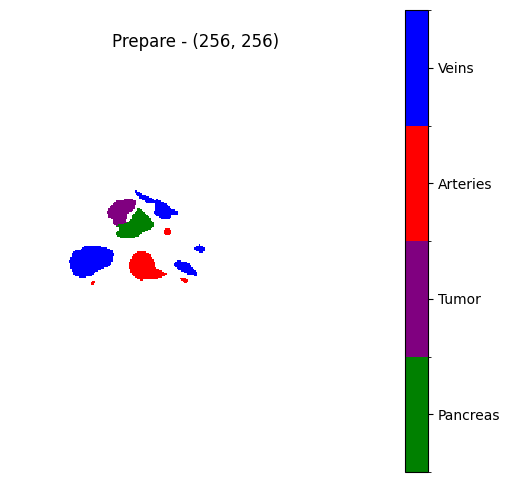

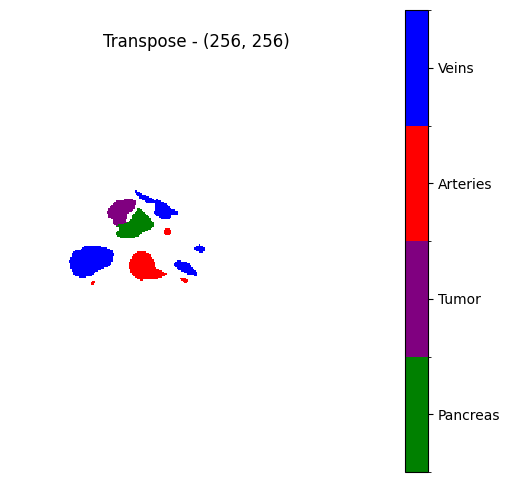

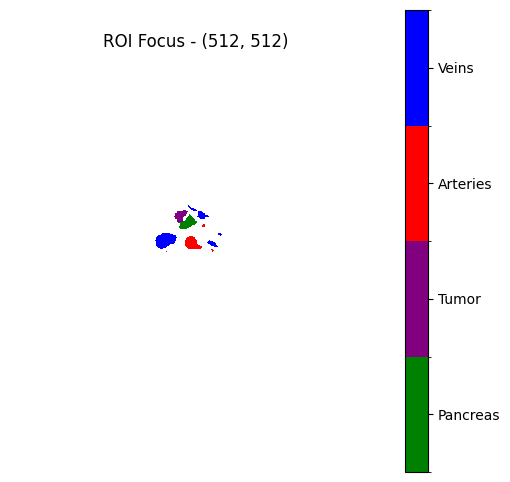

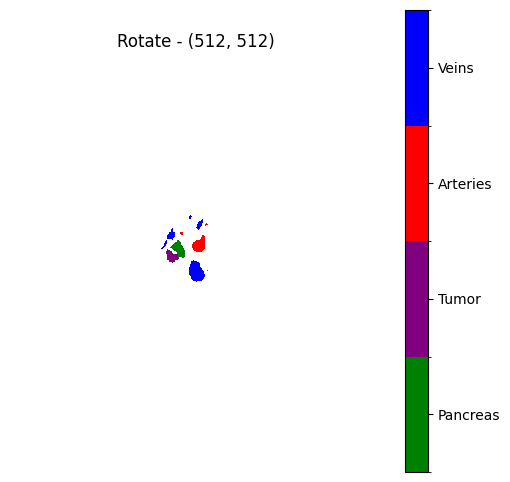

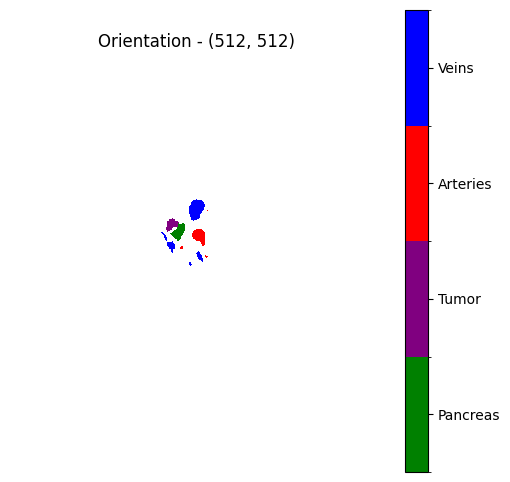

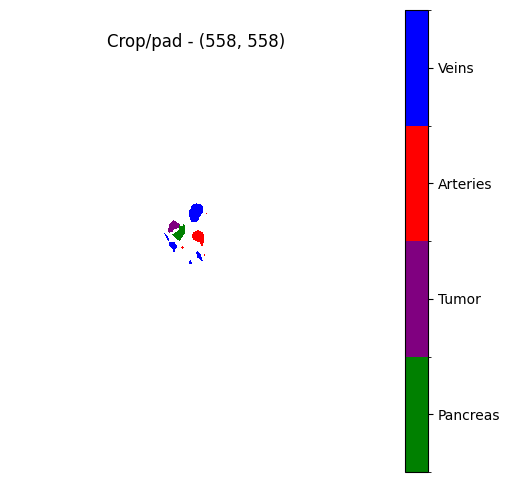

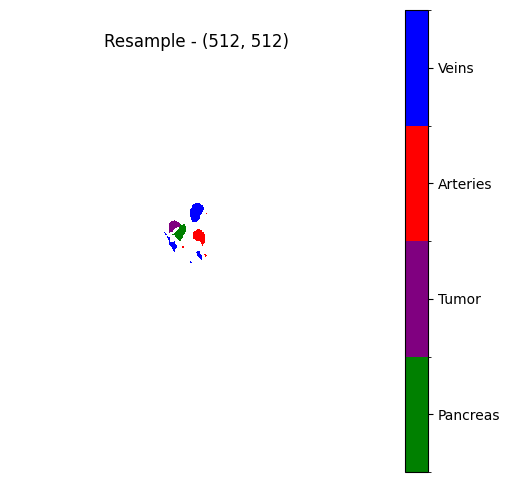

In [104]:
for image, title in snapshots:
    show_mask_slice(image, title)

# __New test__

In [105]:
def reorient_to_standard(image_path, target_orientation=('R', 'P', 'S')):
        image_nii = nib.load(image_path)
        current_orientation = io_orientation(image_nii.affine)
        target_orientation = axcodes2ornt(target_orientation)
        transform = ornt_transform(current_orientation, target_orientation)
        reoriented_data = apply_orientation(image_nii.get_fdata(), transform)
        new_affine = image_nii.affine @ nib.orientations.inv_ornt_aff(transform, image_nii.shape)

        return reoriented_data, new_affine

In [119]:
mask_path = 'data/raw/train/rtum79/SEG/Tumor-rtum79.nii'
rmdata, rmaffine = reorient_to_standard(mask_path)
rmdata = nib.load(mask_path).get_fdata()
print(rmdata.shape)
comp_mask = np.array(rmdata[..., slice_idx])
print(comp_mask.shape)

(512, 512, 103)
(512, 512)


In [127]:
def compare(mask_slice, comp, title="Mask Slice", figsize=(6, 6)):
    masked = np.ma.masked_where(mask_slice == 0, mask_slice)

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    axes[0].imshow(masked, cmap=CMAP, norm=NORM)
    axes[0].set_title(f"{title} - {mask_slice.shape}")
    axes[0].axis('on')

    masked_comp = np.ma.masked_where(comp == 0, comp)

    axes[1].imshow(masked_comp, cmap=CMAP, norm=NORM)
    axes[1].set_title(f"Comp - {comp.shape}")
    axes[1].axis('on')

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    colorbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=NORM, cmap=CMAP),
                            cax=cbar_ax)
    colorbar.set_ticks([1, 2, 3, 4])
    colorbar.set_ticklabels(['Pancreas', 'Tumor', 'Arteries', 'Veins'])

    plt.show()

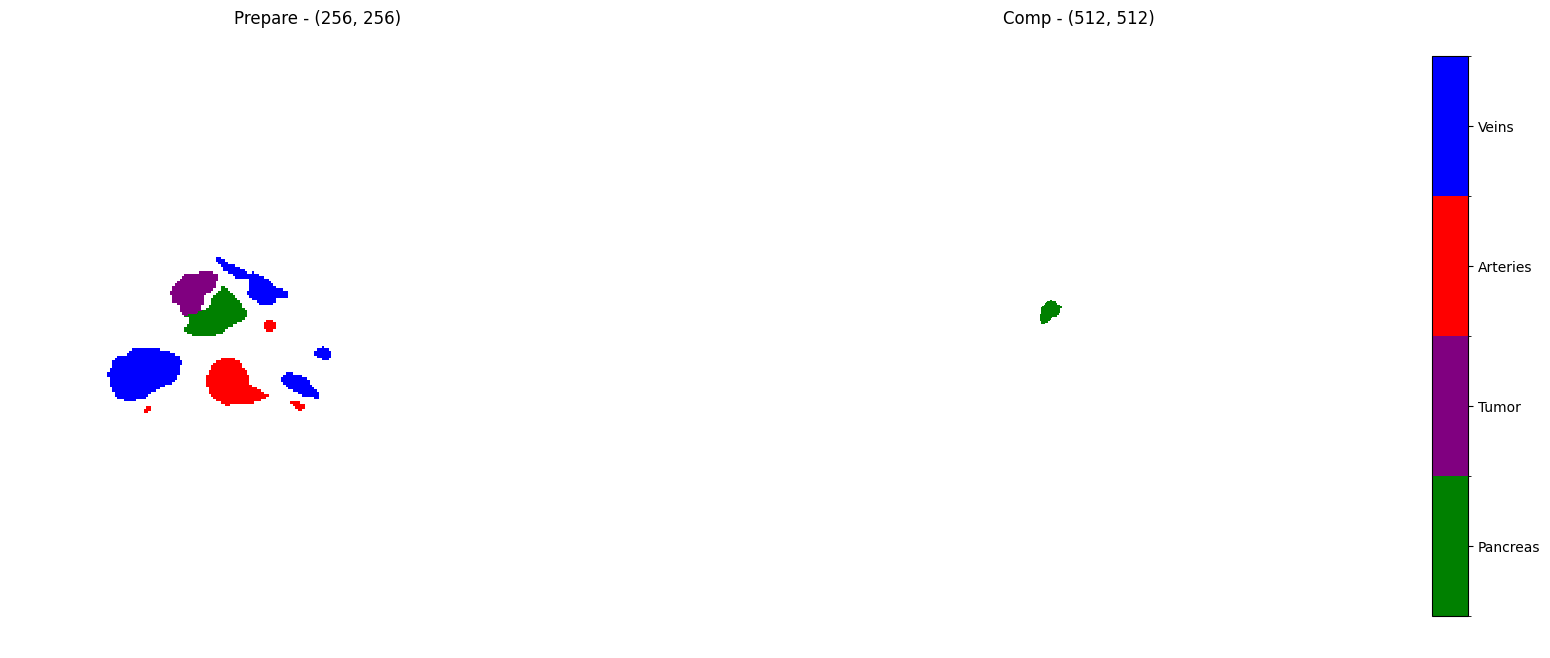

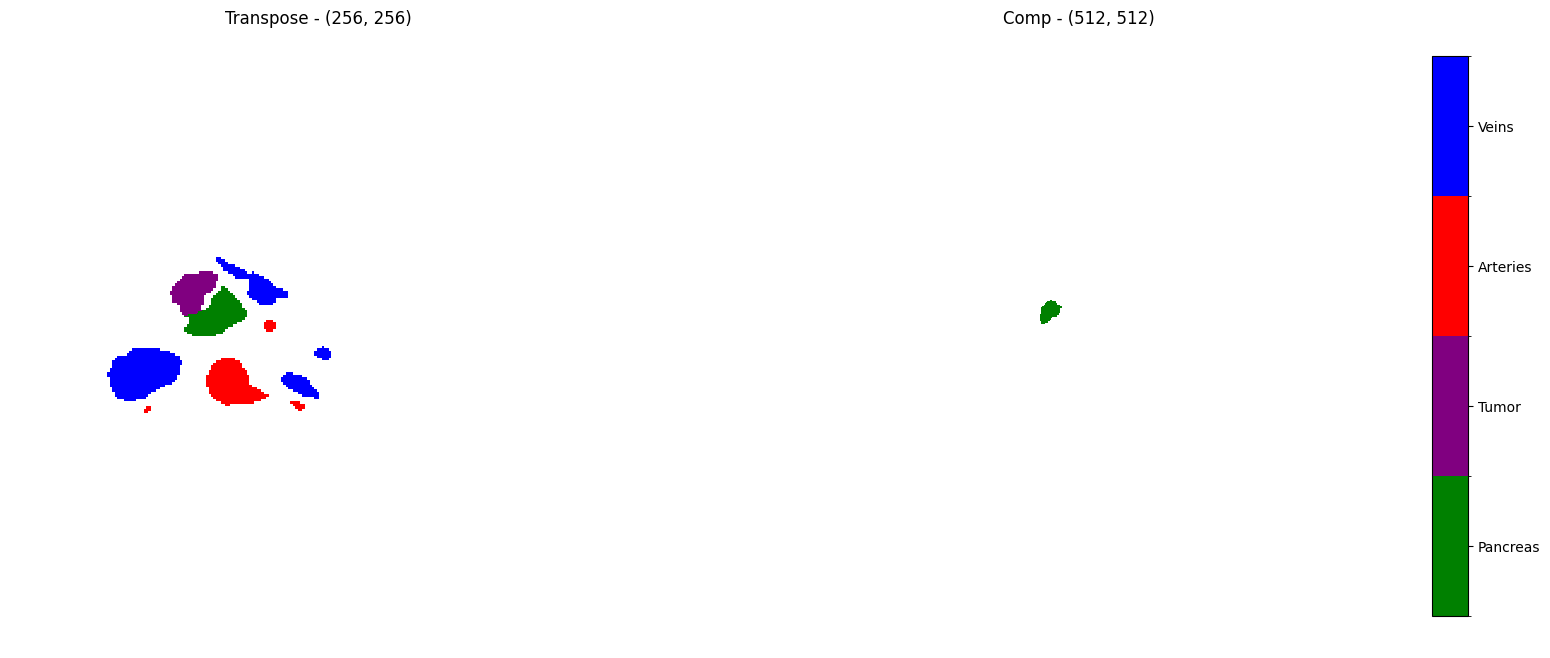

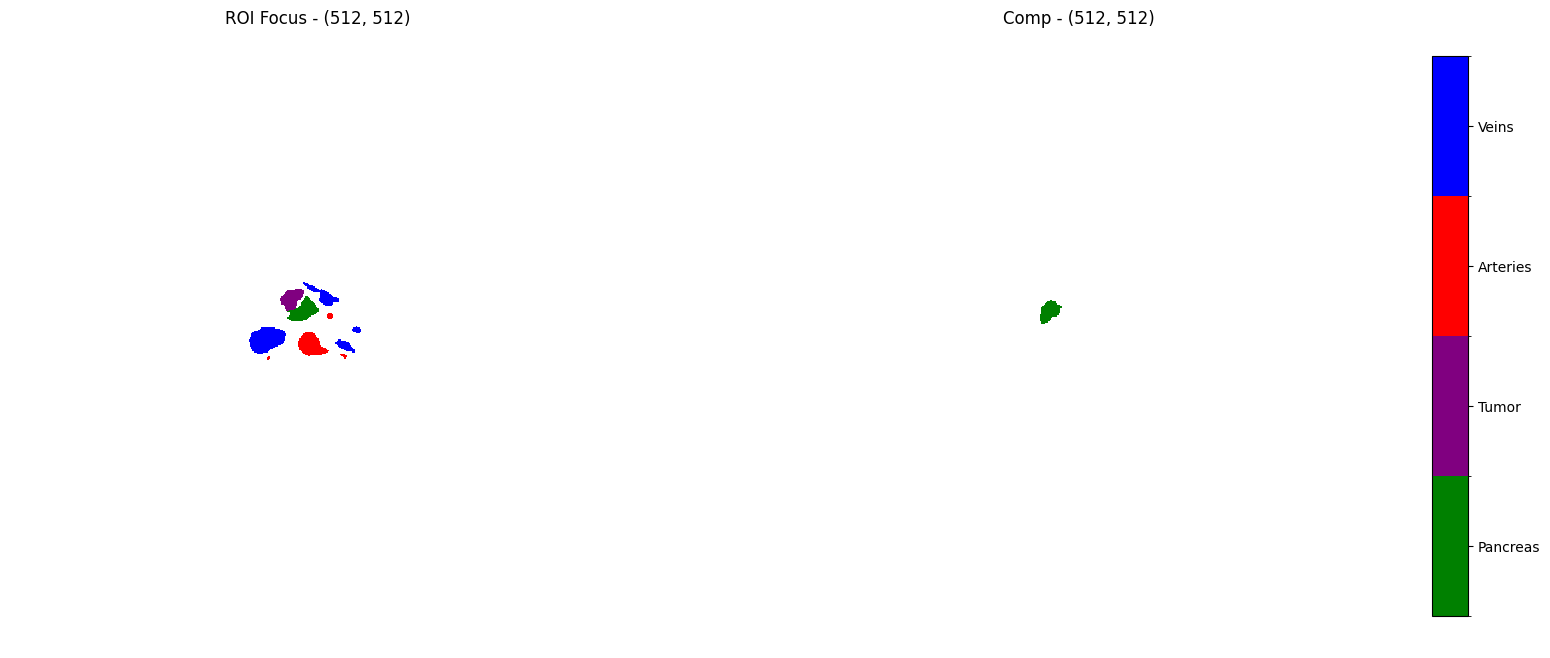

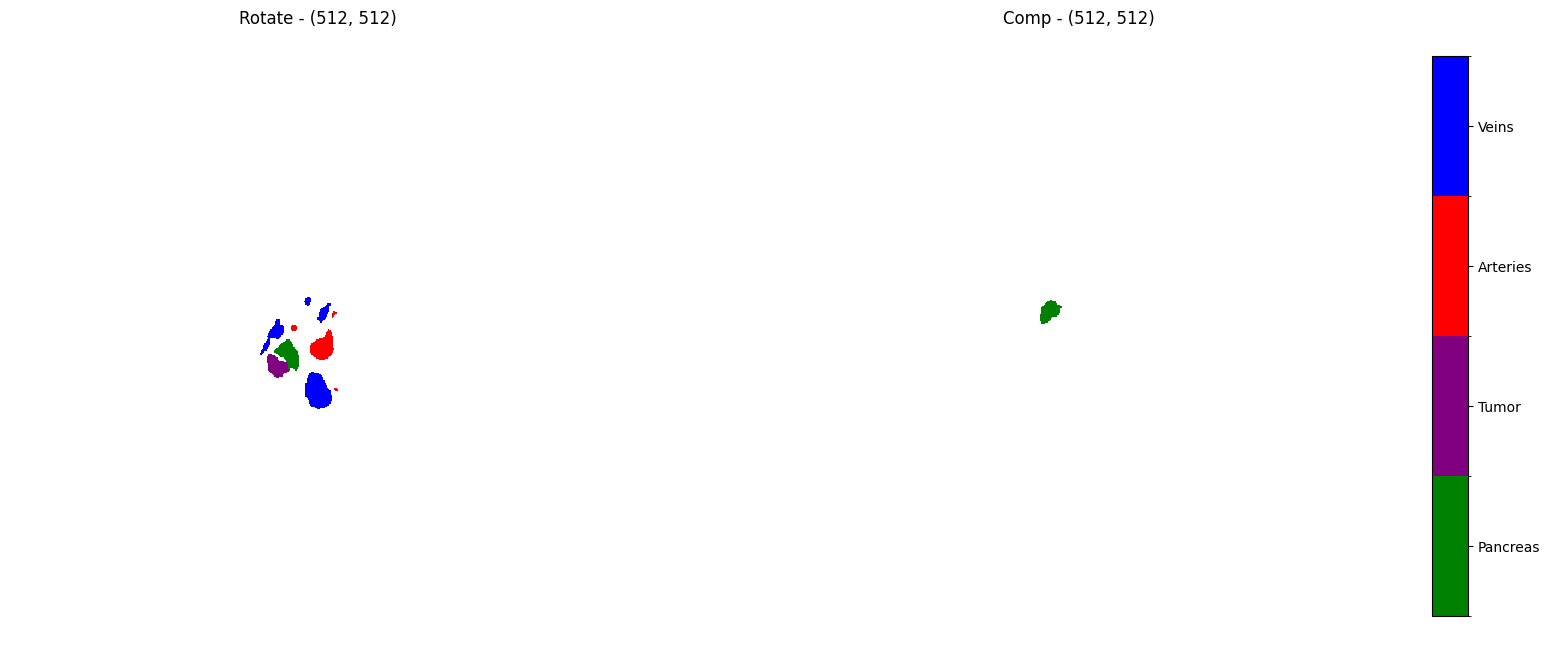

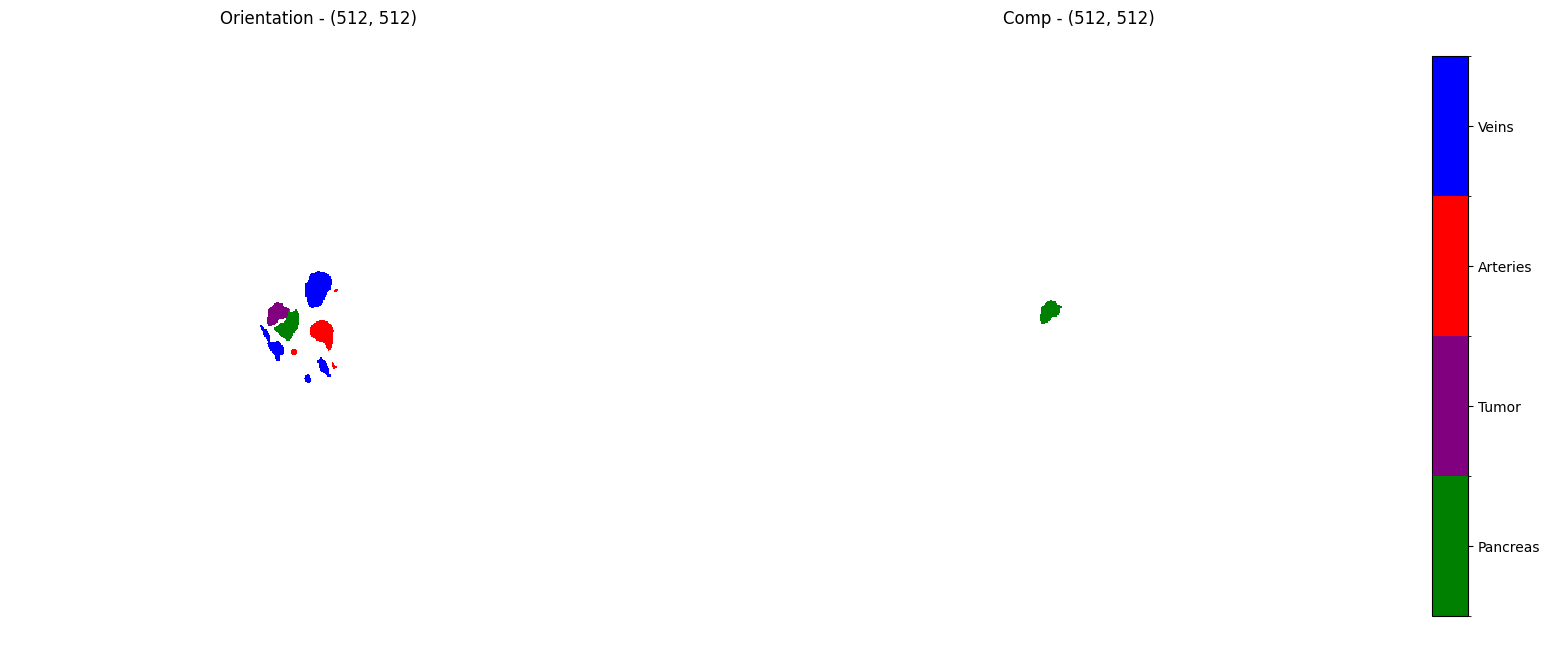

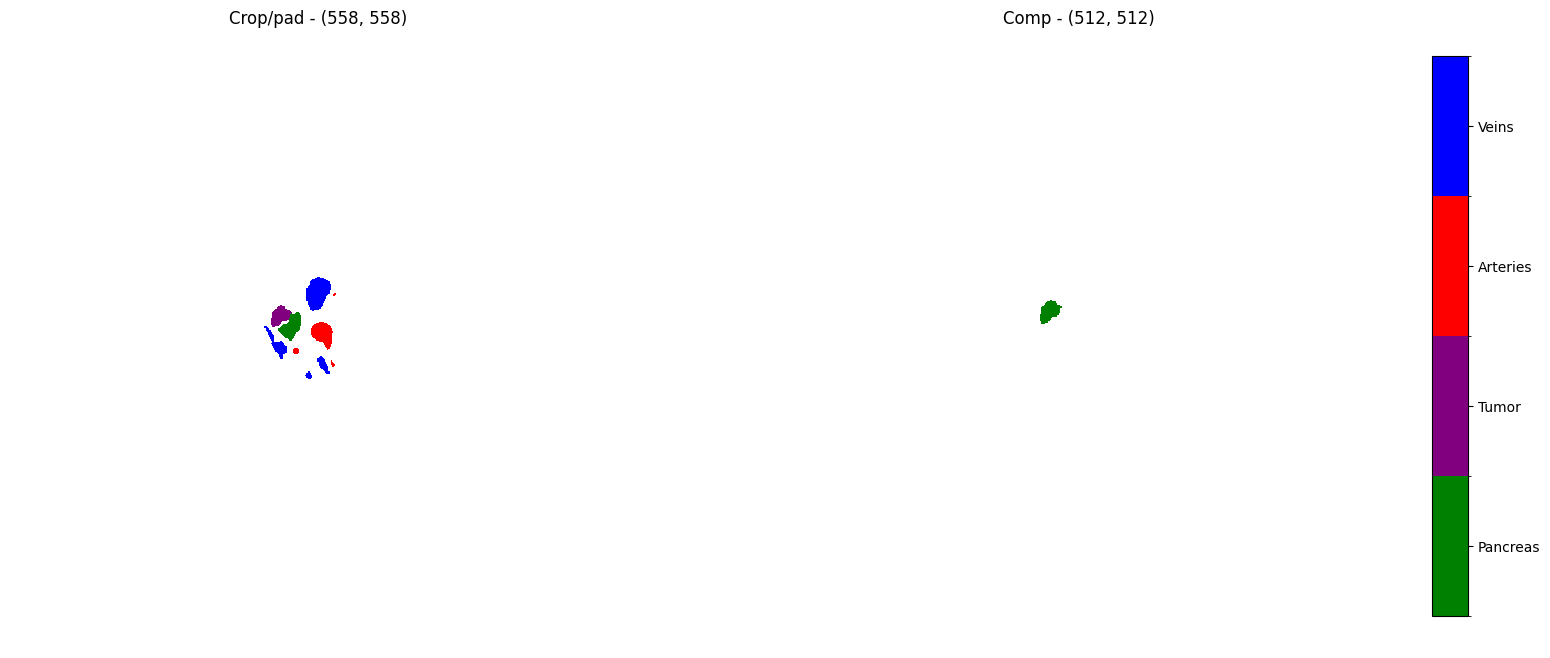

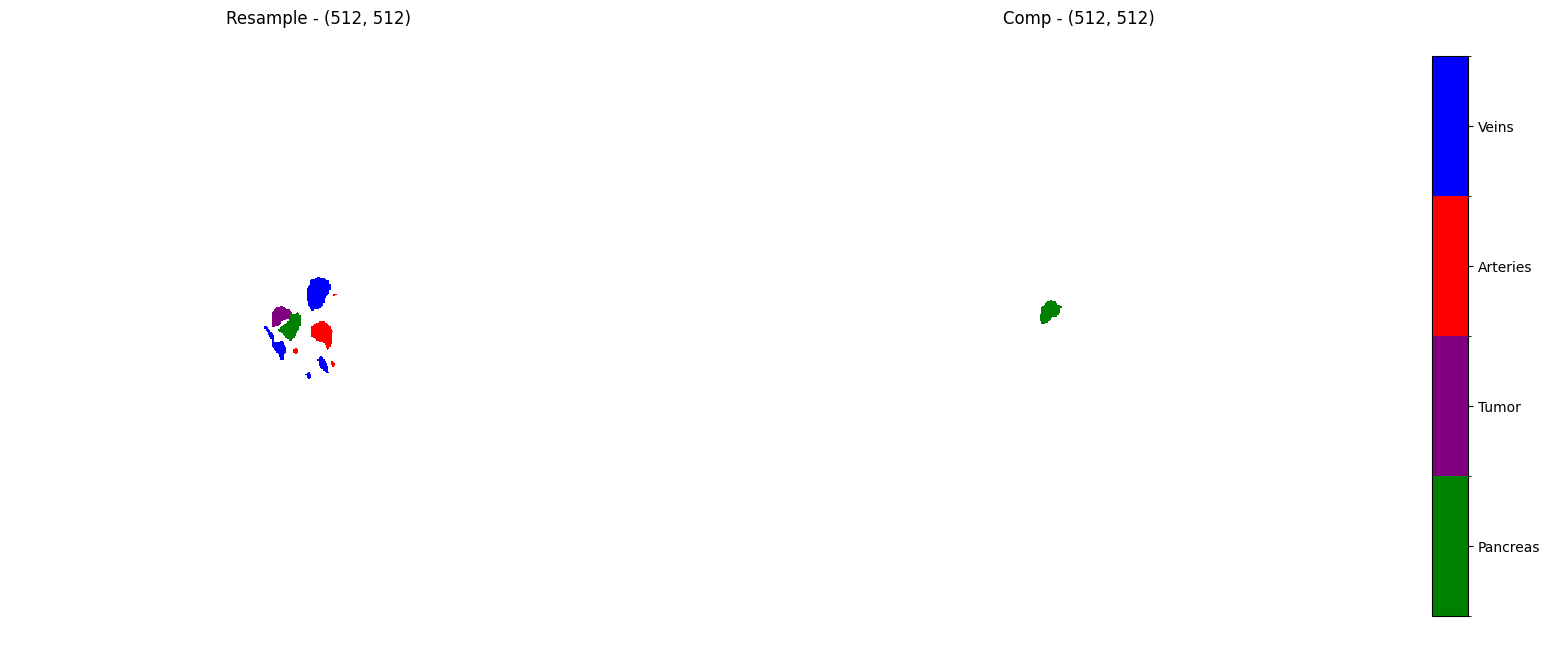

In [120]:
for image, title in snapshots:
    compare(image, comp_mask, title)

In [123]:
def load_combined_mask(patient_dir):
    patient_id = os.path.basename(os.path.normpath(patient_dir))
    image_path = os.path.join(patient_dir, "SEQ", f"CTport-{patient_id}.nii")
    mask_paths = {
        1: os.path.join(patient_dir, "SEG", f"Pancreas-{patient_id}.nii"),
        2: os.path.join(patient_dir, "SEG", f"Tumor-{patient_id}.nii"),
        3: os.path.join(patient_dir, "SEG", f"Arterias-{patient_id}.nii"),
        4: os.path.join(patient_dir, "SEG", f"Venas-{patient_id}.nii"),
    }

    # Get the shape from the first mask
    first = nib.load(next(iter(mask_paths.values()))).get_fdata()
    combined_mask = np.zeros(first.shape, dtype=np.uint8)

    # Load and combine masks
    for label, path in mask_paths.items():
        mask_data = nib.load(path).get_fdata()
        mask_data = (mask_data > 0).astype(np.uint8)  # Binarize
        combined_mask[mask_data > 0] = label  # Assign label

    return combined_mask

In [124]:
combined_mask = load_combined_mask('data/raw/train/rtum79')
print(combined_mask.shape)

(512, 512, 103)


In [125]:
new_comp = combined_mask[..., slice_idx]

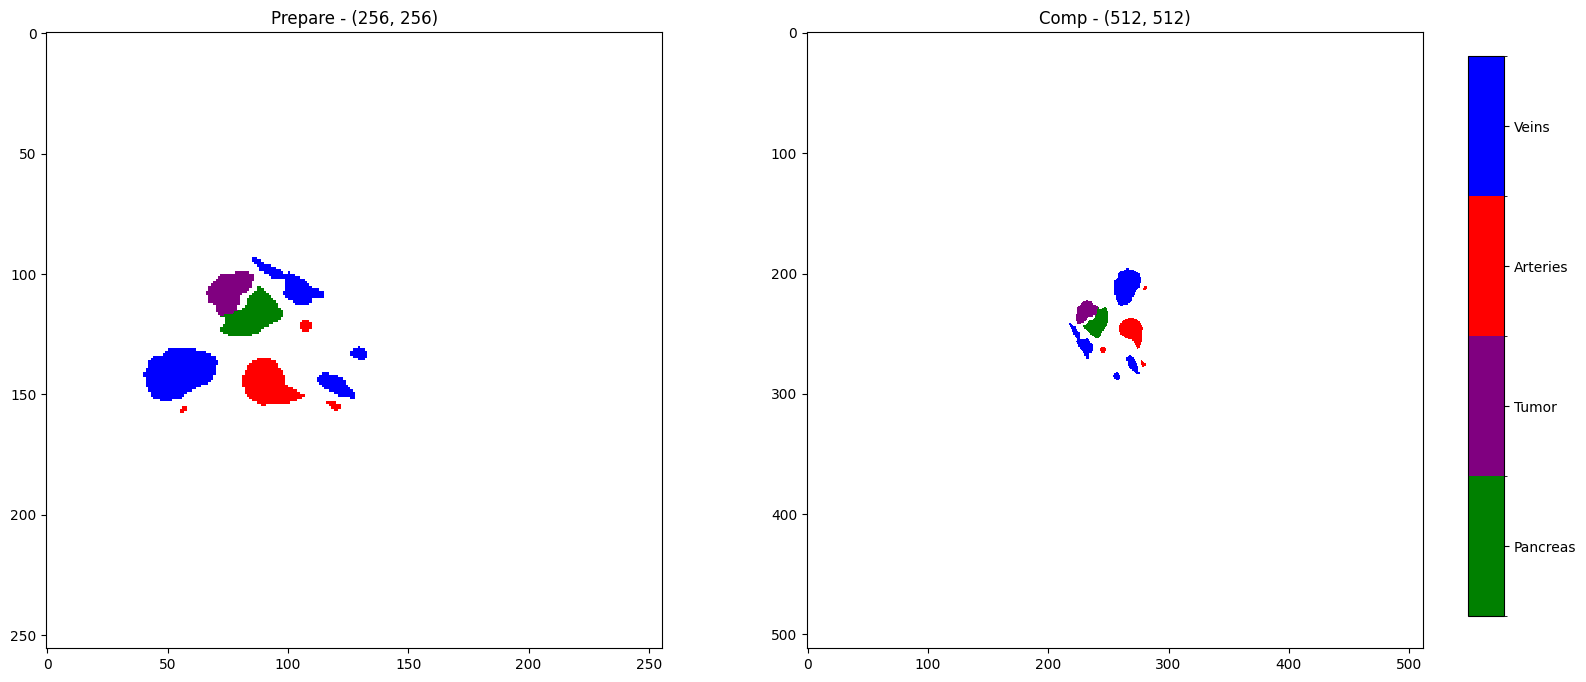

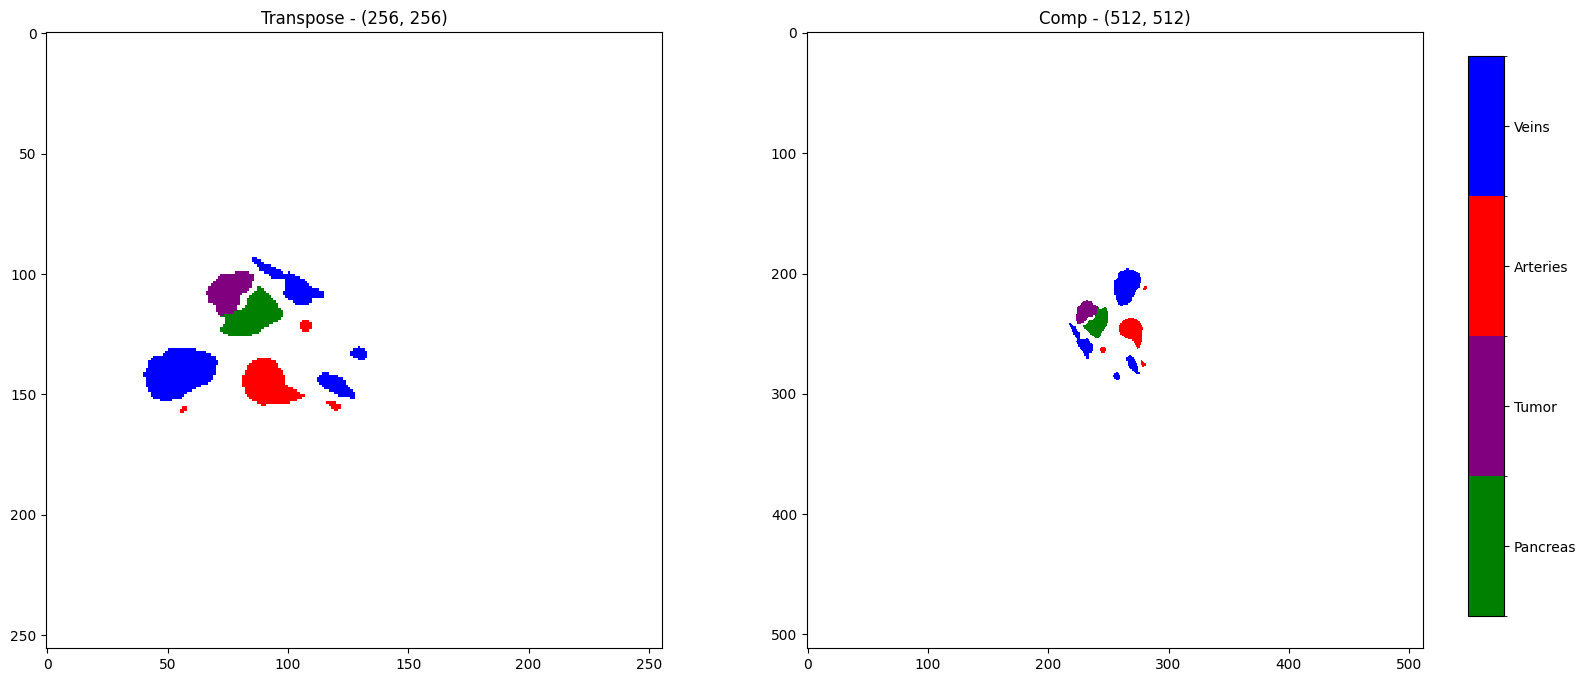

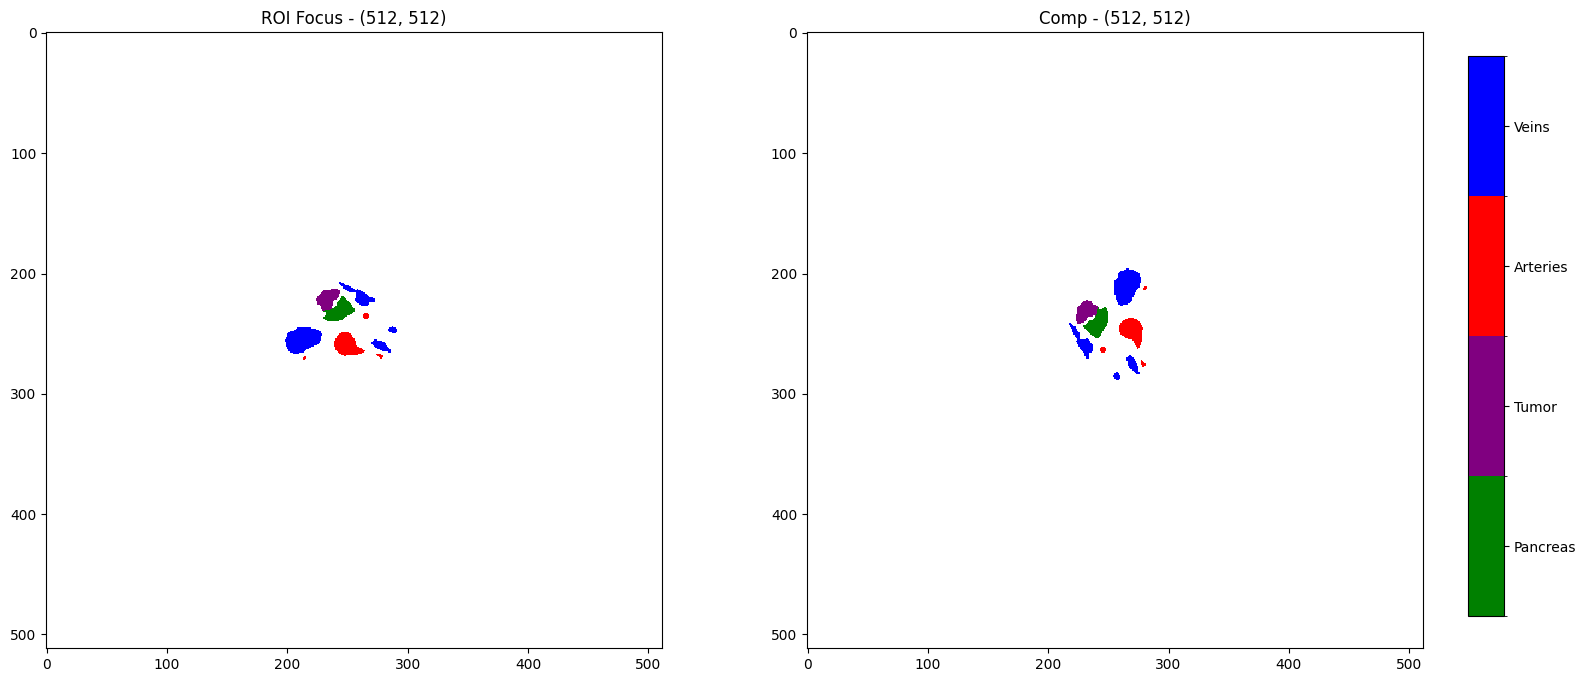

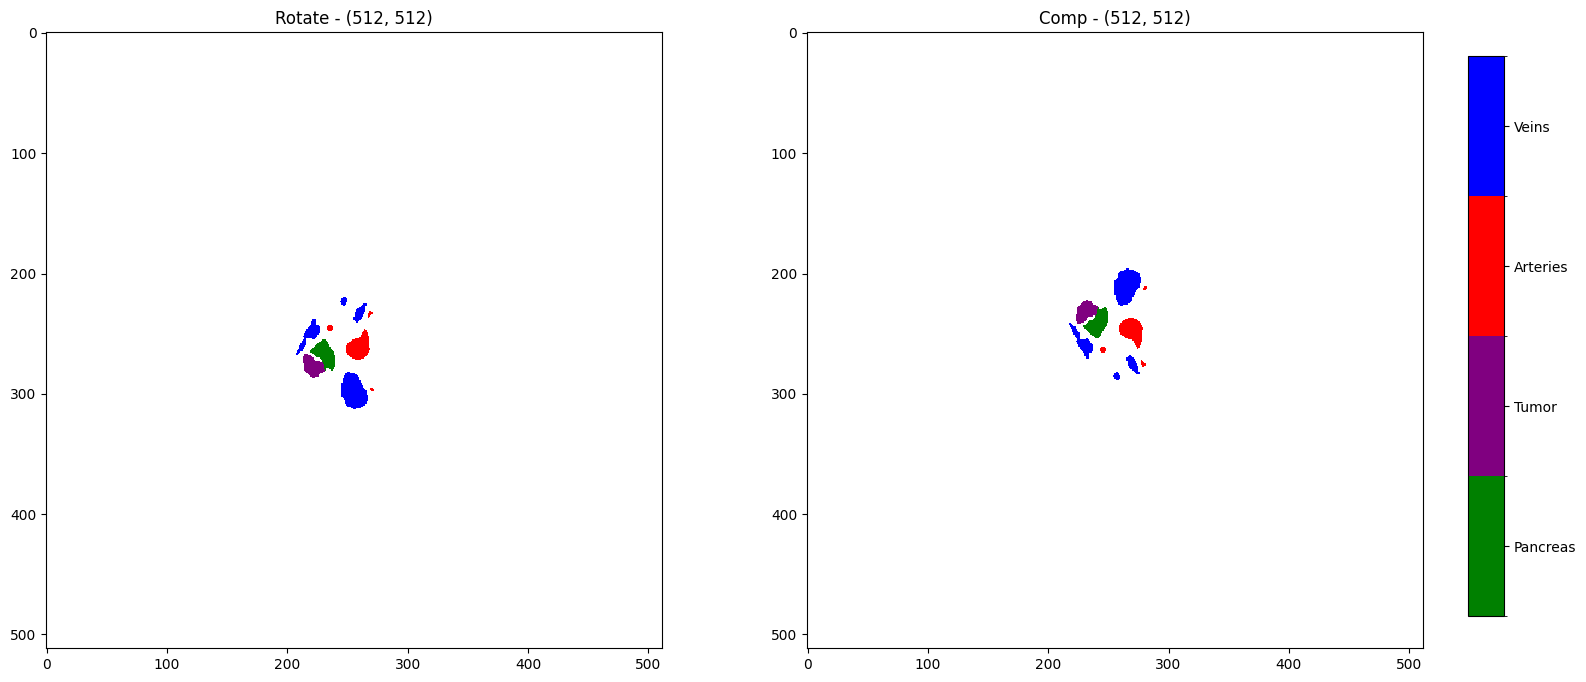

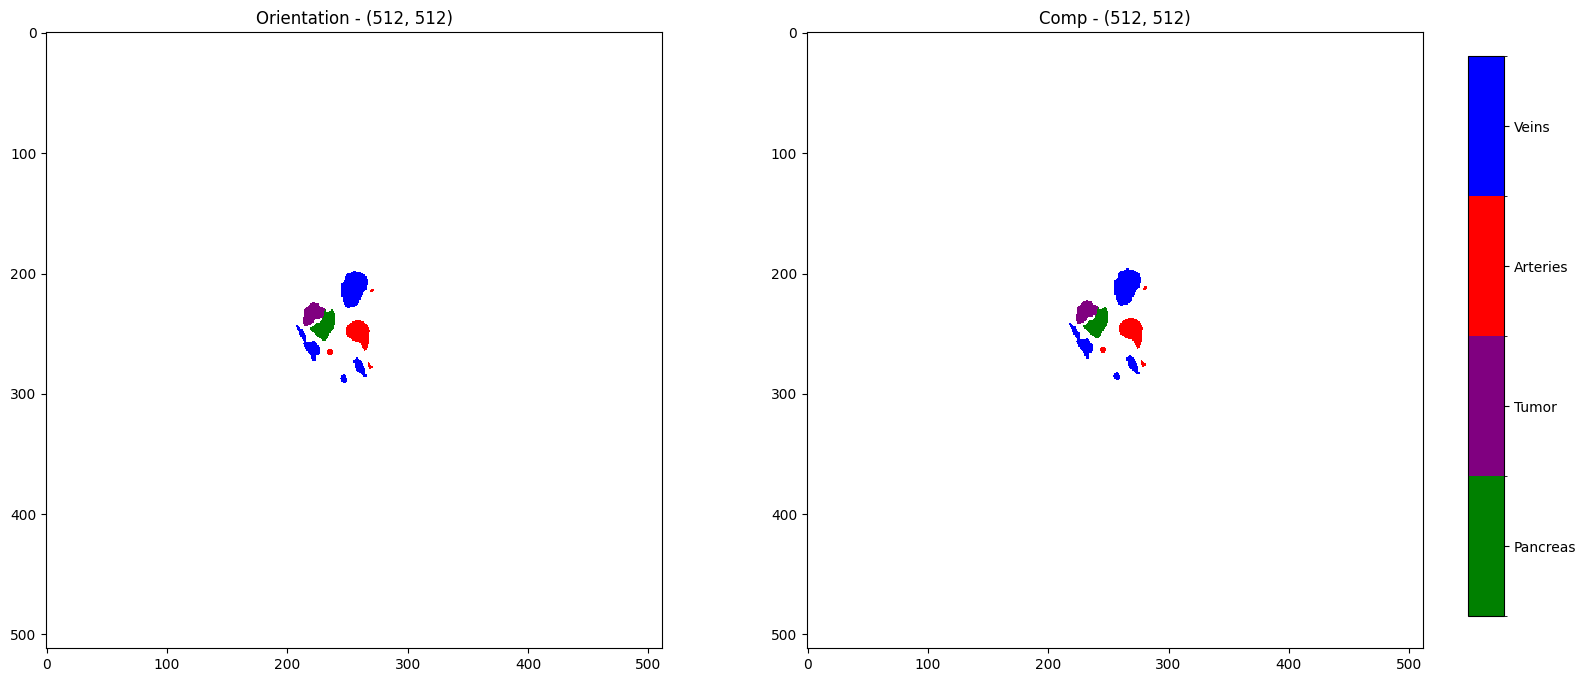

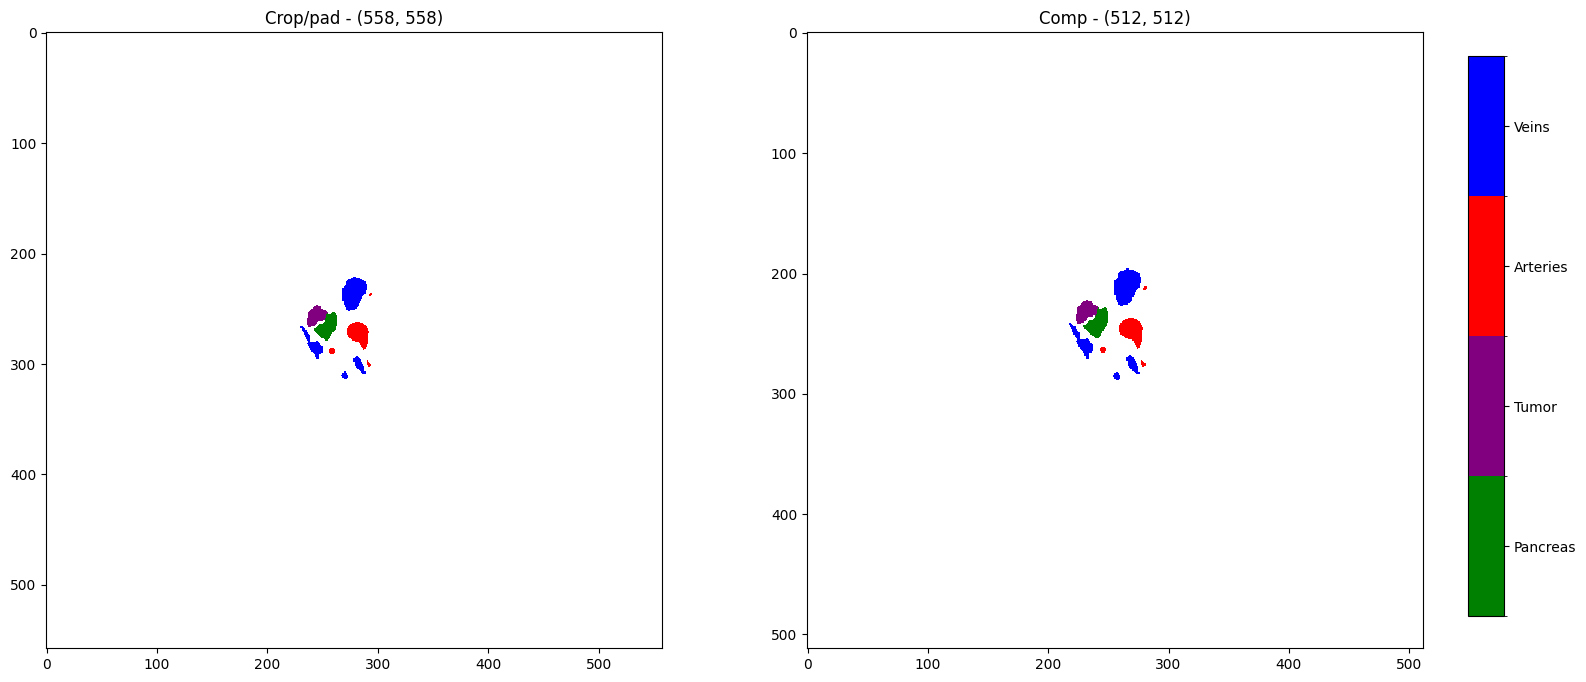

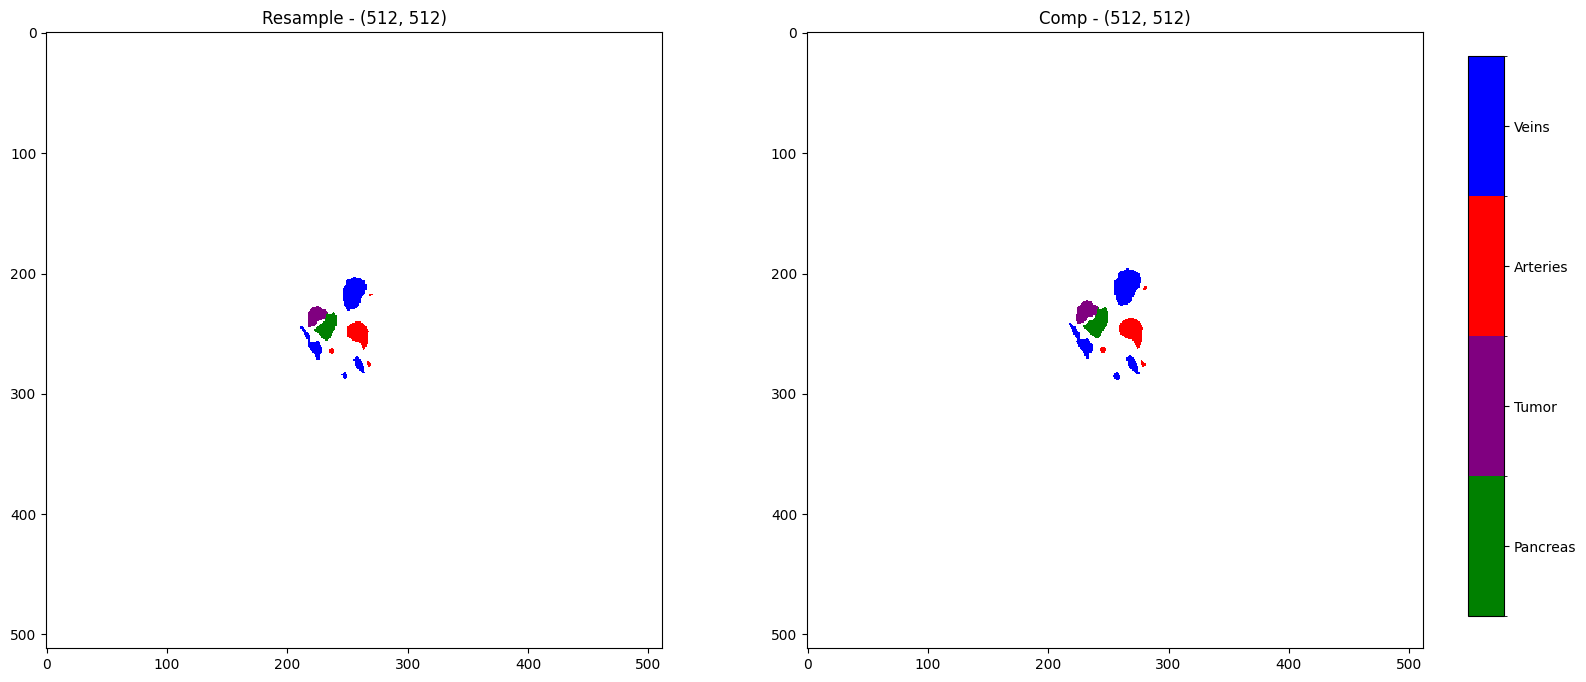

In [128]:
for image, title in snapshots:
    compare(image, new_comp, title)

# __New test__

In [129]:
from src.data.preprocessing import process_volume

In [ ]:
pv, pm, _ = process_volume('data/raw/train/rtum79', target_spacing=(0.8,0.8,1.0))

# __Correct__

In [130]:
# Crop parameters
h_min, h_max = 124, 380
w_min, w_max = 156, 412

# Original data
print(f"ORIGINAL")
original_affine, original_spacing = get_original_data('data/raw/train/', 'rtum79')
print(original_affine)
print(original_spacing)

# Prepare
print(f"PREPARE")
pred_np, mask_np, _ = prepare_tensors_for_visualization(predictions, masks, None)
print(f"pred: {pred_np.shape}")
print(f"mask: {mask_np.shape}")

# Transpose: (D, H, W) -> (H, W, D)
print(f"TRANSPOSE")
pred_np = np.transpose(pred_np, (1, 2, 0))
mask_np = np.transpose(mask_np, (1, 2, 0))
print(f"pred: {pred_np.shape}")
print(f"mask: {mask_np.shape}")

# ROI Focus
print(f"ROI FOCUS")
D = pred_np.shape[2]
rpred = np.zeros((512, 512, D), dtype=pred_np.dtype)
rpred[h_min:h_max, w_min:w_max, :] = pred_np
rmask = np.zeros((512, 512, D), dtype=mask_np.dtype)
rmask[h_min:h_max, w_min:w_max, :] = mask_np
print(f"rpred: {rpred.shape}")
print(f"rmask: {rmask.shape}")

# Rotate
print(f"ROTATE")
rpred = np.rot90(rpred, k=1, axes=(0,1)) # rotate in plane H,W
rmask = np.rot90(rmask, k=1, axes=(0,1))
print(f"rpred: {rpred.shape}")
print(f"rmask: {rmask.shape}")

# Orientation
print(f"ORIENTATION")
current_orientation = axcodes2ornt(('R', 'P', 'S'))
target_orientation = axcodes2ornt(('L', 'P', 'S'))
transform = ornt_transform(current_orientation, target_orientation)
rpred = apply_orientation(rpred, transform)
rmask = apply_orientation(rmask, transform)
print(f"rpred: {rpred.shape}")
print(f"rmask: {rmask.shape}")

# Crop/pad to size
print(f"CROP/PAD")
target_size = (512, 512)
rpred = crop_or_pad_to_size(rpred, target_size)
rmask = crop_or_pad_to_size(rmask, target_size)
print(f"full pred: {rpred.shape}")
print(f"full mask: {rmask.shape}")

# Save
print(f"SAVE")
save_pred_mask(rpred, rmask, save_path, original_affine, ext='correct')

ORIGINAL
('L', 'P', 'S')
[[ -0.87109375   0.           0.         214.        ]
 [  0.          -0.87109375   0.          90.        ]
 [  0.           0.           1.         249.        ]
 [  0.           0.           0.           1.        ]]
(0.87109375, 0.87109375, 1.0)
PREPARE
pred: (103, 256, 256)
mask: (103, 256, 256)
TRANSPOSE
pred: (256, 256, 103)
mask: (256, 256, 103)
ROI FOCUS
rpred: (512, 512, 103)
rmask: (512, 512, 103)
ROTATE
rpred: (512, 512, 103)
rmask: (512, 512, 103)
ORIENTATION
rpred: (512, 512, 103)
rmask: (512, 512, 103)
CROP/PAD
full pred: (512, 512, 103)
full mask: (512, 512, 103)
SAVE


# __Resampled test__

In [3]:
from src.data.dataset2d import PancreasDataset2D
from src.training.setup import get_transforms

In [4]:
config_res = load_config('configs/experiments/deep_aug_9.yaml')
data_dir = 'data/processed/2d_res/train'
patient_id = 'rtum1'
transform = get_transforms(config_res)

In [5]:
res_ds = PancreasDataset2D(
    data_dir=data_dir,
    transform=transform,
    patient_ids=[patient_id]
)

📊 Loading dataset... 92 slices found.


In [6]:
recon_vol, recon_mask = res_ds.get_patient_volume(patient_id)
print(f"vol: {recon_vol.shape}")
print(f"mask: {recon_mask.shape}")

vol: torch.Size([1, 1, 92, 256, 256])
mask: torch.Size([1, 92, 256, 256])


In [7]:
# Prepare the mask
mask = torch.argmax(recon_mask, dim=0).cpu().numpy()
print(f"mask: {mask.shape}")

mask: (92, 256, 256)


In [8]:
# Crop parameters (resampled)
h_min, h_max = 114, 370
w_min, w_max = 158, 414

In [15]:
slice_idx = 28

In [21]:
# Original data
print(f"ORIGINAL")
original_affine, original_spacing = get_original_data('data/raw/train/', patient_id)
print(original_affine)
print(original_spacing)

# Prepare
print(f"PREPARE")
mask_np = recon_mask[0].cpu().numpy()
print(f"mask: {mask_np.shape}")

# Transpose: (D, H, W) -> (H, W, D)
print(f"TRANSPOSE")
mask_np = np.transpose(mask_np, (1, 2, 0))
print(f"mask: {mask_np.shape}")

# ROI Focus
print(f"ROI FOCUS")
D = mask_np.shape[2]
rmask = np.zeros((512, 512, D), dtype=mask_np.dtype)
rmask[h_min:h_max, w_min:w_max, :] = mask_np
print(f"rmask: {rmask.shape}")

# Rotate
print(f"ROTATE")
rmask = np.rot90(rmask, k=1, axes=(0,1))
print(f"rmask: {rmask.shape}")

# Orientation
print(f"ORIENTATION")
current_orientation = axcodes2ornt(('R', 'P', 'S'))
target_orientation = axcodes2ornt(('L', 'P', 'S'))
transform = ornt_transform(current_orientation, target_orientation)
rmask = apply_orientation(rmask, transform)
print(f"rmask: {rmask.shape}")

# Crop/pad to size
print(f"CROP/PAD")
zoom_factors = np.array(original_spacing) / np.array((.8, .8, 1.))
print(zoom_factors)
target_size = np.round(512*zoom_factors[0]).astype(np.int64)
print(target_size)
target_size = (target_size, target_size)
print(target_size)
rmask = crop_or_pad_to_size(rmask, target_size)
print(f"full mask: {rmask.shape}")

# Resample
print(f"RESAMPLE")
rmask = resample_mask_spacing(rmask, target_spacing=original_spacing, current_spacing=(0.8,0.8,1.0))
print(f"rmask: {rmask.shape}")

# Save
print(f"SAVE")
save_path = 'test_save/'
save_mask(rmask, save_path, original_affine, ext=patient_id)

ORIGINAL
('L', 'P', 'S')
[[-7.50000000e-01  0.00000000e+00  0.00000000e+00  2.13000000e+02]
 [ 0.00000000e+00 -7.50000000e-01  0.00000000e+00  8.10000000e+01]
 [ 0.00000000e+00  0.00000000e+00  1.01086962e+00  7.63521729e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
(0.75, 0.75, 1.0108696)
PREPARE
mask: (92, 256, 256)
TRANSPOSE
mask: (256, 256, 92)
ROI FOCUS
rmask: (512, 512, 92)
ROTATE
rmask: (512, 512, 92)
ORIENTATION
rmask: (512, 512, 92)
CROP/PAD
[0.9375     0.9375     1.01086962]
480
(480, 480)
full mask: (480, 480, 92)
RESAMPLE
rmask: (512, 512, 91)
SAVE


## __No resampling__

In [15]:
# Original data
print(f"ORIGINAL")
original_affine, original_spacing = get_original_data('data/raw/train/', patient_id)
print(original_affine)
print(original_spacing)

# Prepare
print(f"PREPARE")
mask_np = recon_mask[0].cpu().numpy()
print(f"mask: {mask_np.shape}")

# Transpose: (D, H, W) -> (H, W, D)
print(f"TRANSPOSE")
mask_np = np.transpose(mask_np, (1, 2, 0))
print(f"mask: {mask_np.shape}")

# ROI Focus
print(f"ROI FOCUS")
D = mask_np.shape[2]
rmask = np.zeros((512, 512, D), dtype=mask_np.dtype)
rmask[h_min:h_max, w_min:w_max, :] = mask_np
print(f"rmask: {rmask.shape}")

# Rotate
print(f"ROTATE")
rmask = np.rot90(rmask, k=1, axes=(0,1))
print(f"rmask: {rmask.shape}")

# Orientation
print(f"ORIENTATION")
current_orientation = axcodes2ornt(('R', 'P', 'S'))
target_orientation = axcodes2ornt(('L', 'P', 'S'))
transform = ornt_transform(current_orientation, target_orientation)
rmask = apply_orientation(rmask, transform)
print(f"rmask: {rmask.shape}")

# Crop/pad to size
print(f"CROP/PAD")
target_size = (512, 512)
print(target_size)
rmask = crop_or_pad_to_size(rmask, target_size)
print(f"full mask: {rmask.shape}")

# Resample
print(f"UPDATE AFFINE")
new_affine = update_affine(original_affine, (.8,.8,1.0))
print(new_affine)

# Save
print(f"SAVE")
save_path = 'test_save/'
save_mask(rmask, save_path, new_affine, ext=f'{patient_id}_no_res')

ORIGINAL
('L', 'P', 'S')
[[-7.50000000e-01  0.00000000e+00  0.00000000e+00  2.13000000e+02]
 [ 0.00000000e+00 -7.50000000e-01  0.00000000e+00  8.10000000e+01]
 [ 0.00000000e+00  0.00000000e+00  1.01086962e+00  7.63521729e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
(0.75, 0.75, 1.0108696)
PREPARE
mask: (92, 256, 256)
TRANSPOSE
mask: (256, 256, 92)
ROI FOCUS
rmask: (512, 512, 92)
ROTATE
rmask: (512, 512, 92)
ORIENTATION
rmask: (512, 512, 92)
CROP/PAD
(512, 512)
full mask: (512, 512, 92)
UPDATE AFFINE
[[ -0.8          0.           0.         213.        ]
 [  0.          -0.8          0.          81.        ]
 [  0.           0.           1.         763.52172852]
 [  0.           0.           0.           1.        ]]
SAVE


# __Test using function__

In [19]:
from src.data.preprocessing import reverse_preprocess_mask
from src.utils.data import save_segmentation_mask
from src.data.dataset2d import PancreasDataset2D
from src.training.setup import get_transforms

## Previous

In [5]:
config_res = load_config('configs/experiments/deep_aug_9.yaml')
data_dir = 'data/processed/2d_res/train'
patient_id = 'rtum1'
transform = get_transforms(config_res)

In [6]:
res_ds = PancreasDataset2D(
    data_dir=data_dir,
    transform=transform,
    patient_ids=[patient_id]
)

📊 Loading dataset... 92 slices found.


In [35]:
recon_vol, recon_mask = res_ds.get_patient_volume(patient_id)
print(f"vol: {recon_vol.shape}")
print(f"mask: {recon_mask.shape}")

vol: torch.Size([1, 1, 92, 256, 256])
mask: torch.Size([1, 92, 256, 256])


In [37]:
mask = recon_mask[0].cpu().numpy()
print(f"mask: {mask.shape}")

mask: (92, 256, 256)


In [9]:
# Crop parameters (resampled)
h_min, h_max = 114, 370
w_min, w_max = 158, 414

### Get data

In [14]:
from src.utils.data import get_original_info
from nibabel.orientations import io_orientation, axcodes2ornt, ornt_transform, apply_orientation

In [21]:
original_affine, original_spacing, original_orientation = get_original_info('data/raw/train/', patient_id)
print(original_affine)
print(original_spacing)
print(original_orientation)

[[-7.50000000e-01  0.00000000e+00  0.00000000e+00  2.13000000e+02]
 [ 0.00000000e+00 -7.50000000e-01  0.00000000e+00  8.10000000e+01]
 [ 0.00000000e+00  0.00000000e+00  1.01086962e+00  7.63521729e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
(0.75, 0.75, 1.0108696)
('L', 'P', 'S')


In [22]:
orientation_transform = ornt_transform(axcodes2ornt(('R','P','S')), axcodes2ornt(original_orientation))

### Apply function

In [39]:
resampled_mask, resampled_affine = reverse_preprocess_mask(
    mask,
    (.8,.8,1.),
    original_affine,
    h_min, h_max,
    w_min, w_max,
    orientation_transform=orientation_transform,
    original_spacing=original_spacing
)

Unique values in the mask: [0 1 2 3 4]
Mask shape after transpose: (256, 256, 92)
Mask shape after undoing ROI: (512, 512, 92)
Mask shape after undoing rotation: (512, 512, 92)
Mask shape after undoing reorientation: (512, 512, 92)
Mask shape after cropping/padding to size: (480, 480, 92)
Mask shape after resampling to original spacing: (512, 512, 91)


In [40]:
file_path = f'test_save/{patient_id}_resampled_mask.nii'
save_segmentation_mask(resampled_mask, resampled_affine, file_path)

### Without resampling

In [38]:
mask_no_res, affine_no_res = reverse_preprocess_mask(
    mask,
    (.8,.8,1.),
    original_affine,
    h_min, h_max,
    w_min, w_max,
    orientation_transform=orientation_transform
)
print(affine_no_res)
file_path = f'test_save/{patient_id}_no_resampled_mask.nii'
save_segmentation_mask(mask_no_res, affine_no_res, file_path)

Unique values in the mask: [0 1 2 3 4]
Mask shape after transpose: (256, 256, 92)
Mask shape after undoing ROI: (512, 512, 92)
Mask shape after undoing rotation: (512, 512, 92)
Mask shape after undoing reorientation: (512, 512, 92)
Mask shape after cropping/padding to size: (512, 512, 92)
[[ -0.8          0.           0.         213.        ]
 [  0.          -0.8          0.          81.        ]
 [  0.           0.           1.         763.52172852]
 [  0.           0.           0.           1.        ]]
